In [50]:
# Standard library import
import re
import warnings
import time
from difflib import get_close_matches
import os
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings
import gradio as gr

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all info, 1=info, 2=warning info, 3=error info
tf.get_logger().setLevel('ERROR')

# Scientific computing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import scipy.sparse as sp

# Natural language processing libraries 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning and model libraries 
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sk_train_test_split, KFold
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split as sp_train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


In [2]:
# read files
ratings = pd.read_csv('rating.csv')
movies = pd.read_csv('movie.csv')
tags = pd.read_csv('tag.csv')
directors = pd.read_csv('imdb_top_1000.csv')

# merge rating.csv and movie.csv by movieID
rating_movie_merged = pd.merge(ratings, movies, on='movieId')

# merge rating.csv and tag.csv
merged_data = pd.merge(rating_movie_merged, tags, on=['movieId','userId'], how='inner')
merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53
1,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54
2,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28


In [3]:
# modify title column format
def process_movie_title(title):
    # Extract the last parentheses if it contains a year 
    match = re.search(r"\(\d{4}\)$", title)  # Match parentheses with a 4-digit number at the end of the title
    year = match.group(0) if match else ""  # Extract the year if present, otherwise keep it empty

    # Remove any parentheses and content in the middle of the title
    title_without_parentheses = re.sub(r"\s*\([^)]*\)\s*", "", title)  # Remove any non-year parentheses in the middle of the title

    # Move "The", "A", or "An" from the end of the title to the beginning if present
    if ', The' in title_without_parentheses:
        title_without_parentheses = 'The ' + title_without_parentheses.replace(', The', '')
    elif ', A' in title_without_parentheses:
        title_without_parentheses = 'A ' + title_without_parentheses.replace(', A', '')
    elif ', An' in title_without_parentheses:
        title_without_parentheses = 'An ' + title_without_parentheses.replace(', An', '')

    # Add the year back to the end of the title (if it was extracted)
    if year:
        title_without_parentheses = f"{title_without_parentheses} {year}"

    return title_without_parentheses.strip()  # Return the final processed title, ensuring no extra spaces

# Apply to the entire dataset
merged_data['title'] = merged_data['title'].apply(process_movie_title)

# Check the processed result
merged_data['title'].head(10)

0      In My Father's Den (2004)
1    The Science of Sleep (2006)
2    The Science of Sleep (2006)
3                     CJ7 (2008)
4                     CJ7 (2008)
5                     CJ7 (2008)
6                     CJ7 (2008)
7                  Frozen (2013)
8                  Frozen (2013)
9                  Frozen (2013)
Name: title, dtype: object

In [4]:
directors.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [5]:
# add director information to merged_data
directors = directors.rename(columns={'Series_Title': 'shared_title', 'Director': 'director'})

# define a function to unite the movie title format for future merging
def extract_movie_name(title):
    return re.sub(r'\s+\(\d{4}\)$', '', title).strip()

# extract movie title
merged_data['shared_title'] = merged_data['title'].apply(extract_movie_name)

# merge merged_data and directors using 'shared_title'
merged_data = pd.merge(merged_data, directors[['shared_title','director']], on='shared_title', how='left')
merged_data['director'] = merged_data['director'].fillna('unknown')
merged_data = merged_data.drop(columns=['shared_title'])
merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,director
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53,unknown
1,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54,unknown
2,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59,unknown
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32,unknown
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28,unknown


In [6]:
# remove extra timestamp
merged_data = merged_data.drop(columns=['timestamp_y']).rename(columns={'timestamp_x': 'timestamp'})
merged_data.head()

,userId,movieId,rating,timestamp,title,genres,tag,director
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,unknown
1,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,surreal,unknown
2,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unusual,unknown
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,cute,unknown
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,emotional,unknown


In [7]:
# check null value
merged_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          1
director     0
dtype: int64

In [8]:
# mark NaN as 'unknown'
merged_data['tag'] = merged_data['tag'].fillna('unknown')
merged_data.isnull().sum() 

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
director     0
dtype: int64

In [9]:
merged_data.describe()

,userId,movieId,rating
count,391445.000000,391445.000000,391445.000000
mean,67291.897587,32766.306189,3.780652
std,42227.513945,35997.920748,1.024136
min,65.000000,1.000000,0.500000
25%,27898.000000,2502.000000,3.000000
50%,66635.000000,7361.000000,4.000000
75%,106755.000000,63072.000000,4.500000
max,138472.000000,131258.000000,5.000000


In [10]:
# combine different tags under same movie
merged_data = merged_data.groupby(['userId', 'movieId', 'title', 'genres', 'director'], as_index=False).agg({
    'rating': 'mean',
    'timestamp': 'first',
    'tag': lambda x: ', '.join(x)
})

merged_data.head()

,userId,movieId,title,genres,director,rating,timestamp,tag
0,65,27866,In My Father's Den (2004),Drama,unknown,4.0,2011-05-09 16:05:59,New Zealand
1,65,48082,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unknown,4.5,2011-05-09 16:26:19,"surreal, unusual"
2,65,58652,CJ7 (2008),Children|Comedy|Sci-Fi,unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ..."
3,96,106696,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Rom...,unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi..."
4,121,778,Trainspotting (1996),Comedy|Crime|Drama,Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not..."


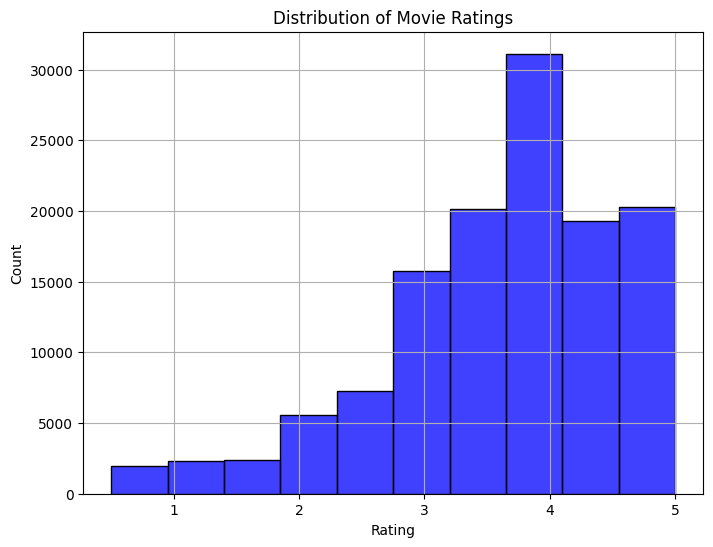

In [11]:
# visualize rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['rating'], bins=10, kde=False, color='blue', kde_kws={'bw_adjust': 2})
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

This is a positively skewed distribution, i.e. most of the ratings for movies tend to be high. Many users tend to give high ratings (close to 5) to the movies they like, and fewer users give very low ratings (such as 1).

In [12]:
# split genres col, make each genre a list
merged_data['genres_split'] = merged_data['genres'].str.split('|')

# use explode to show genre as independent row and save the result as a new dataframe
genres_exploded = merged_data.explode('genres_split')

# filter out (no genres listed)
genres_exploded = genres_exploded[genres_exploded['genres_split'] != '(no genres listed)']

# count each genre's appearance
genre_counts = genres_exploded['genres_split'].value_counts()
genre_counts

genres_split
Drama          62926
Comedy         40755
Thriller       35589
Action         33221
Adventure      24075
Romance        22346
Sci-Fi         22114
Crime          22103
Fantasy        14305
Mystery        12883
Horror         11437
Animation       7510
Children        7161
War             6361
IMAX            6271
Musical         4356
Documentary     2961
Western         1872
Film-Noir       1859
Name: count, dtype: int64

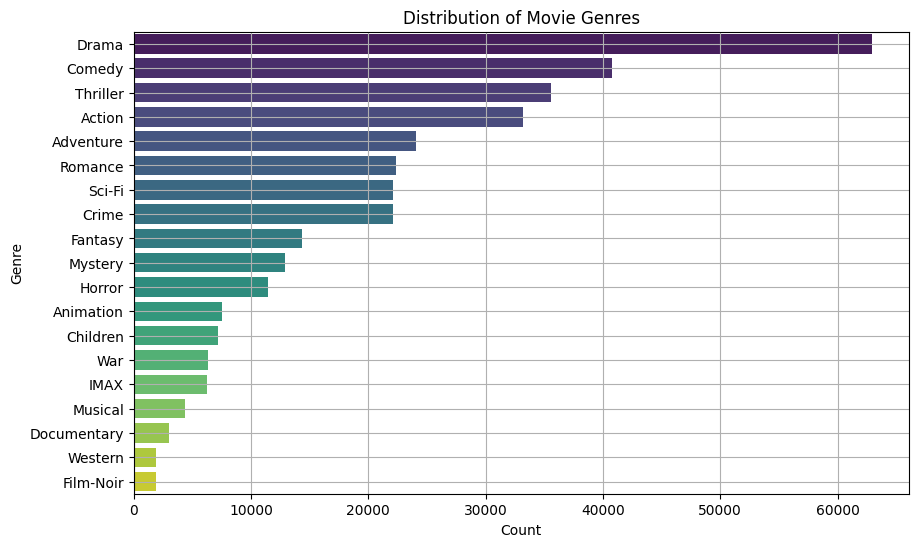

In [13]:
# visualize genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

Most popular movie genre is Drama. Comedy, Thriller, Action is also popular. Film-Noir, Western and  Musical have less audience.

In [14]:
# check NaN
merged_data.isnull().sum()

userId          0
movieId         0
title           0
genres          0
director        0
rating          0
timestamp       0
tag             0
genres_split    0
dtype: int64

In [15]:
# convert timestamp to datetime format
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# extract year and month
merged_data['year'] = merged_data['timestamp'].dt.year
merged_data['month'] = merged_data['timestamp'].dt.month

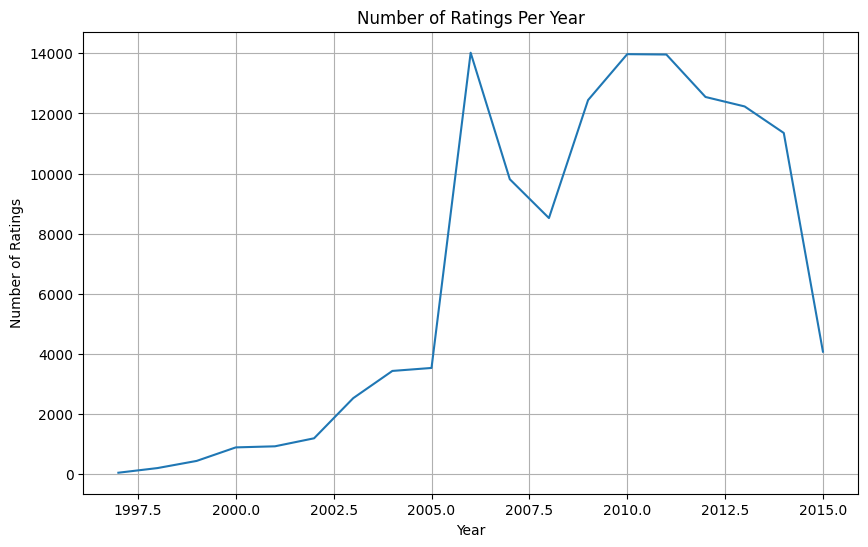

In [16]:
# calculate ratings based on year
ratings_per_year = merged_data.groupby('year').size()

# visualize
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.title('Number of Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

There is a sharp increase in the number of ratings between 2005 and 2010, followed by a significant drop after 2011. Such fluctuations may be related to specific events or trends in the dataset, or to changes in the movie recommendation system and user behavior.

In [17]:
# check NaN
merged_data.isnull().sum()

userId          0
movieId         0
title           0
genres          0
director        0
rating          0
timestamp       0
tag             0
genres_split    0
year            0
month           0
dtype: int64

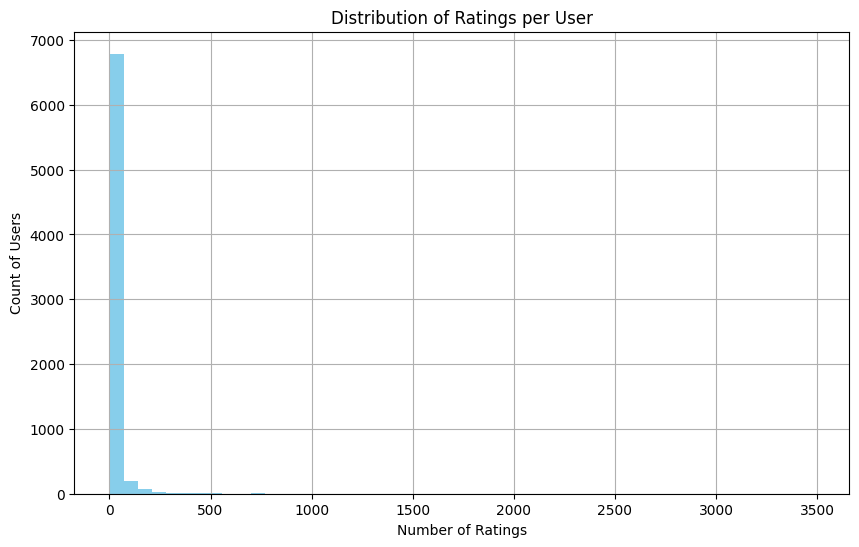

In [18]:
# count the number of ratings for each user 
user_rating_counts = merged_data.groupby('userId').size()

# visualize Distribution of Ratings per User
plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, bins=50, color='skyblue')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)
plt.show()

This is a typical long-tail distribution, where most users have a low number of ratings (less than 100), while a few active users have a large number of ratings.

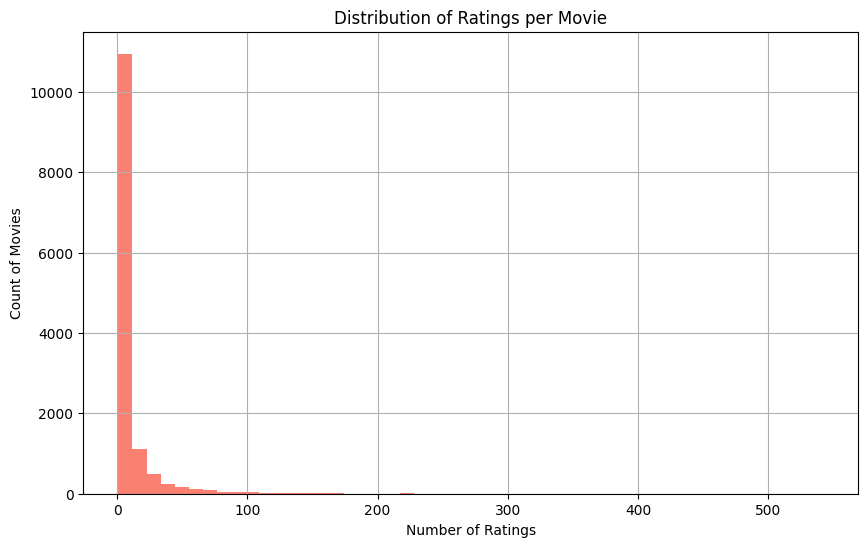

In [19]:
# Count the number of ratings for each movie
movie_rating_counts = merged_data.groupby('movieId').size()

# visualize 'Distribution of Ratings per Movie
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts, bins=50, color='salmon')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.grid(True)
plt.show()

This is also a typical long-tail distribution, where most movies have very few ratings, while a few movies have a very large number of ratings.

In [20]:
# Computing the sparsity of the rating matrix
total_possible_ratings = merged_data['userId'].nunique() * merged_data['movieId'].nunique()
actual_ratings = len(merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9987


The sparsity of the rating matrix is 0.9987, which means that 99.87% of user-movie pairs have no ratings, and only 0.13% of user-movie pairs have rating data. This shows that the dataset is very sparse, with relatively few ratings, and most users have not rated most movies.

In [21]:
# Filter out users who have rated less than 20 times
active_users = user_rating_counts[user_rating_counts >= 20].index
final_merged_data = merged_data[merged_data['userId'].isin(active_users)]

# Filter out movies with less than 50 ratings
popular_movies = movie_rating_counts[movie_rating_counts >= 50].index
final_merged_data = final_merged_data[merged_data['movieId'].isin(popular_movies)]

In [23]:
# Computing the sparsity of the rating matrix again
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9333


Sparsity got improved.

In [24]:
# LabelEncoder for userId 
user_encoder = LabelEncoder()
final_merged_data['userId_encoded'] = user_encoder.fit_transform(final_merged_data['userId'])

# LabelEncoder for movieId:
movie_encoder = LabelEncoder()
final_merged_data['movieId_encoded'] = movie_encoder.fit_transform(final_merged_data['movieId'])

# check data after labelencoding
final_merged_data[['userId', 'userId_encoded', 'movieId', 'movieId_encoded']].head()

,userId,userId_encoded,movieId,movieId_encoded
22,129,0,2706,191
23,129,0,3556,219
26,129,0,4878,247
29,129,0,8641,323
38,129,0,80549,478


In [26]:
# Start the timer
start_time = time.time()

# Define the rating scale and prepare the dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(final_merged_data[['userId_encoded', 'movieId_encoded', 'rating']], reader)

# Define the parameter grid for SVD
param_grid = {
    'n_factors': [50, 100],  # Reduce the number of factors
    'n_epochs': [20, 30],    # Reduce the number of epochs
    'lr_all': [0.005],       # Fix the learning rate to a single value
    'reg_all': [0.02]        # Fix the regularization parameter to a single value
}

# Perform GridSearchCV for parameter tuning (using Surprise's GridSearchCV)
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fit GridSearchCV on the dataset
grid_search.fit(data)

# Output the best parameters based on RMSE
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters for SVD model:", grid_search.best_params['rmse'])

# Train the final model with the best parameters
best_svd = grid_search.best_estimator['rmse']
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Perform predictions on the test set (train/test split is done inside the GridSearchCV)
testset = trainset.build_anti_testset()
predictions = best_svd.test(testset
# Evaluate the model performance
accuracy.rmse(predictions)
accuracy.mae(predictions)

# End the timer
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Best RMSE score: 0.8034280513264863
Best parameters for SVD model: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 0.4924
MAE:  0.3803
Total execution time: 5.48 seconds


The RMSE and MAE results show that the prediction error of the model is within a reasonable range, indicating that the performance of the model is good.

In [38]:
def get_user_based_recommendations(user_id, final_merged_data, svd_model, n_recommendations=5):
    """Generate movie recommendations for a specific user based on the SVD model."""
    
    # Build a dictionary of movie IDs and movie titles in advance to optimize search efficiency
    movie_id_to_title = dict(zip(final_merged_data['movieId_encoded'], final_merged_data['title']))
    
    # Get movies that the user has rated
    user_rated_movies = final_merged_data[final_merged_data['userId_encoded'] == user_id]['movieId_encoded'].values
    all_movies = final_merged_data['movieId_encoded'].unique()
    
    # Filter out movies that users have not rated
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    
    # Use SVD model to predict ratings and rank based on ratings
    movie_scores = []
    for movie_id in unrated_movies:
        prediction = svd_model.predict(user_id, movie_id)  
        movie_scores.append((movie_id, prediction.est))  
    
    # sort movies based on predicted scores
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)
    
    # Get the IDs of the first n recommended movies
    top_movie_ids = [movie_id for movie_id, score in movie_scores[:n_recommendations]]
    
    # Return movie title based on movie ID
    recommendations = [movie_id_to_title[movie_id] for movie_id in top_movie_ids]
    
    return recommendations
re = get_user_based_recommendations(user_id=100, final_merged_data=final_merged_data, svd_model=best_svd)
re

['The Matrix (1999)',
 'Amelie (2001)',
 'My Neighbor Totoro (1988)',
 'The Fall (2006)',
 'Rear Window (1954)']

In [40]:
# use MultiLabelBinarizer to One-Hot encode genres

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(merged_data['genres_split'])

# convert the result of One-Hot to DataFrame and add it to the original dataset and ensure the indices match
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=merged_data.index)
merged_data = pd.concat([merged_data, genres_encoded_df], axis=1)

# delete the original genres column and genres_split coloumn
merged_data.drop(['genres', 'genres_split'], axis=1, inplace=True)
merged_data.head()

,userId,movieId,title,director,rating,timestamp,tag,year,month,(no genres listed),...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,65,27866,In My Father's Den (2004),unknown,4.0,2011-05-09 16:05:59,New Zealand,2011,5,0,...,0,0,0,0,0,0,0,0,0,0
1,65,48082,The Science of Sleep (2006),unknown,4.5,2011-05-09 16:26:19,"surreal, unusual",2011,5,0,...,0,0,0,0,0,1,0,0,0,0
2,65,58652,CJ7 (2008),unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ...",2011,5,0,...,0,0,0,0,0,0,1,0,0,0
3,96,106696,Frozen (2013),unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi...",2014,3,0,...,0,0,0,1,0,1,0,0,0,0
4,121,778,Trainspotting (1996),Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not...",2011,3,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
def recommend_movies_based_on_genres(movie_title, merged_data, n_recommendations=5):
    """
    Recommends movies based on genres similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie for which to recommend similar movies.
    merged_data (DataFrame): The DataFrame containing the merged movie data with one-hot encoded genres.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    List of recommended movies.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Also convert the input to lowercase
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    movie_id = merged_data[merged_data['title'] == original_matched_title]['movieId'].values[0]
        
    # Select numeric columns (assumed to be one-hot encoded genres)
    genre_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ensure the movie_id exists in the dataset
    if movie_id not in merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found in the dataset.")
    
    # Get the index and vector of the matched movie
    movie_idx = merged_data[merged_data['movieId'] == movie_id].index[0]
    movie_vector = merged_data.loc[movie_idx, genre_columns].values.reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, merged_data[genre_columns].values).flatten()
    
    # Get indices of the most similar movies (excluding itself)
    similar_indices = similarity_scores.argsort()[::-1][1:n_recommendations+1]
    
    # Collect recommended movies without scores (for user output)
    recommended_movies = []
    seen_titles = set()  # Track already recommended titles
    for idx in similar_indices:
        movie_title = merged_data.iloc[idx]['title']
        if movie_title not in seen_titles:
            seen_titles.add(movie_title)
            recommended_movies.append(movie_title)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break   
            
    # Filter out the matched movie itself from recommendations
    filtered_recommendations = [title for title in recommended_movies if title != original_matched_title]
    
    return filtered_recommendations[:n_recommendations] 

# test the function 
movie_title = "love"  
recommended_movies = recommend_movies_based_on_genres(movie_title, merged_data, n_recommendations=5)
recommended_movies

['Darkon (2006)',
 'Now You See Me (2013)',
 '20 Feet from Stardom (2013)',
 'Interstellar (2014)',
 'Only Lovers Left Alive (2013)']

In [44]:
merged_data['tag'].value_counts()

tag
comedy                                                                                                                                                               317
sci-fi                                                                                                                                                               278
classic                                                                                                                                                              272
seen more than once                                                                                                                                                  264
erlend's DVDs                                                                                                                                                        262
                                                                                                                                                       

In [54]:
# handle tag column to get ready for tag-based recommendations
# Define stopwords 
stop_words = set(stopwords.words('english'))

def preprocess_tags(text):
    if not isinstance(text, str):
        return ''
    
    tags = text.split(',')     # Split the tags by commas

    # Clean and process each tag
    cleaned_tags = []
    for tag in tags:
        tag = tag.strip() # Remove leading/trailing spaces
        tag = tag.lower() # Convert to lowercase
        tag = re.sub(r'[^\w\s]', '', tag) # Remove special characters and punctuation (except words and spaces)
        tag = ' '.join([word for word in tag.split() if word not in stop_words]) # Remove stopwords

        # Append the cleaned tag to the list if it's not empty
        if tag:
            cleaned_tags.append(tag)

    # Remove duplicates by converting to a set 
    unique_tags = list(set(cleaned_tags))

    # Recombine tags into a single string 
    cleaned_text = ', '.join(unique_tags)

    return cleaned_text

# Apply the function to 'tag' column
merged_data['tags_processed'] = merged_data['tag'].fillna('').apply(preprocess_tags)
merged_data['tags_processed'].head()

0                                          new zealand
1                                     surreal, unusual
2       stephen chow, cute, girls play boys, emotional
3    unnecessary villain, music, storyline, feminis...
4    nudity full frontal notable, dark comedy, drug...
Name: tags_processed, dtype: object

In [48]:
# use TF-IDF to vectorize `tags` colomn 
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(merged_data['tags_processed'])

In [65]:
def recommend_movies_based_on_tags(movie_title, merged_data, tags_tfidf_matrix, n_recommendations=5):
    """
    Recommends movies based on tags similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data (DataFrame): The DataFrame containing the movie data with TF-IDF vectorized tags.
    tags_tfidf_matrix (ndarray): The TF-IDF matrix representing the tags of the movies.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of recommended movies.
    """
    
    # Step 1: Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie ID and index
    movie_id = merged_data[merged_data['title'] == original_matched_title]['movieId'].values[0]
    
    # Ensure the movie ID exists in the dataset
    if movie_id not in merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found.")
    
    # Get the index and vector of the target movie
    movie_idx = merged_data[merged_data['movieId'] == movie_id].index[0]
    movie_vector = tags_tfidf_matrix[movie_idx].reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, tags_tfidf_matrix).flatten()
    
    # Get indices of top similar movies (excluding itself), requesting more to handle duplicates
    similar_indices = similarity_scores.argsort()[::-1][1:(n_recommendations * 5)]  # Request more in case of duplicates
    
    # Collect recommended movie titles
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles
    
    for idx in similar_indices:
        movie_title = merged_data.iloc[idx]['title']
        
        # Only add unique movie titles (skip duplicates and the original movie)
        if movie_title not in seen_titles and movie_title != original_matched_title:
            seen_titles.add(movie_title)
            recommended_movies.append(movie_title)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    # Ensure we return exactly the requested number of recommendations
    return recommended_movies[:n_recommendations]

# Test the function 
movie_title = "frozen"  
recommended_movies = recommend_movies_based_on_tags(movie_title, merged_data, tags_tfidf_matrix, n_recommendations=5)
recommended_movies


['James and the Giant Peach (1996)',
 'Mulan (1998)',
 'The Lion King (1994)',
 'Tekkonkinkreet (2006)',
 'Saawariya (2007)']

In [86]:
def recommend_movies_by_director(movie_title, merged_data, n_recommendations=5):
    """
    Recommends movies by the same director, based on the input movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data (DataFrame): The DataFrame containing the movie data, including director information.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of recommended movies by the same director, or a message if no director is found.
    """
    
    # Find the movie title and get the corresponding director
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        return []

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title and corresponding director
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    director = merged_data[merged_data['title'] == original_matched_title]['director'].values[0]
    
    # Check if the director is found
    if director == 'unknown':
        return []

    # Recommend movies by the same director
    movies_by_director = merged_data[merged_data['director'] == director]
    
    # Exclude the original movie from recommendations
    movies_by_director = movies_by_director[movies_by_director['title'] != original_matched_title]
    
    # Collect unique recommendations
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles

    for title in movies_by_director['title']:
        if title not in seen_titles:
            seen_titles.add(title)
            recommended_movies.append(title)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    return recommended_movies[:n_recommendations]

# test the function
movie_title = "black sawn" 
recommended_movies = recommend_movies_by_director(movie_title, merged_data, n_recommendations=5)
recommended_movies

['Requiem for a Dream (2000)', 'The Wrestler (2008)']

In [98]:
# NEED TO MODIFY,WEIGHT=0.5 IS THE SAME RESTULT AS 1
def combined_recommendation(movie_title_or_id, merged_data, tags_tfidf_matrix, genre_weight=0.5, tag_weight=0.5, n_recommendations=5):
    """
    Combines recommendations based on genres, tags, and directors if applicable.
    
    Parameters:
    movie_title_or_id (str or int): The title of the movie or user ID to search.
    merged_data (DataFrame): The DataFrame containing the movie data, including genres, tags, and director information.
    tags_tfidf_matrix (ndarray): The TF-IDF matrix representing the tags of the movies.
    genre_weight (float): The weight to apply to genre-based recommendations.
    tag_weight (float): The weight to apply to tag-based recommendations.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of recommended movies.
    """

    # Initialize variables to store recommendations
    genre_similar_movies = []
    tag_similar_movies = []
    director_recommendations = []

    # Check if the input is a movie title (assuming titles are strings) or a user ID (int)
    if isinstance(movie_title_or_id, str):
        # Handle movie title input, including director-based recommendations

        # Get genre-based recommendations (handle ValueError inside function)
        genre_similar_movies = recommend_movies_based_on_genres(movie_title_or_id, merged_data, n_recommendations)

        # Get tag-based recommendations (catch IndexError)
        try:
            tag_similar_movies = recommend_movies_based_on_tags(movie_title_or_id, merged_data, tags_tfidf_matrix, n_recommendations)
        except IndexError as e:
            print(f"Tag-based recommendation error (IndexError): {e}. Proceeding with genre-based recommendations.")

        # Get director-based recommendations if available
        director_recommendations = recommend_movies_by_director(movie_title_or_id, merged_data, n_recommendations=2)
        
    else:
        # If input is a user ID, proceed with genre and tag recommendations
        genre_similar_movies = recommend_movies_based_on_genres(movie_title_or_id, merged_data, n_recommendations)
        try:
            tag_similar_movies = recommend_movies_based_on_tags(movie_title_or_id, merged_data, tags_tfidf_matrix, n_recommendations)
        except IndexError as e:
            print(f"Tag-based recommendation error (IndexError): {e}. Proceeding with genre-based recommendations.")
    
    # Combine recommendations (starting with director-based if available)
    combined_recommendations = {}

    # Add genre-based recommendations to the combined dictionary
    for genre_movie in genre_similar_movies:
        normalized_genre_movie = genre_movie.lower().strip()
        combined_recommendations[normalized_genre_movie] = genre_weight

    # Add tag-based recommendations, updating scores if they already exist
    for tag_movie in tag_similar_movies:
        normalized_tag_movie = tag_movie.lower().strip()
        if normalized_tag_movie in combined_recommendations:
            combined_recommendations[normalized_tag_movie] += tag_weight
        else:
            combined_recommendations[normalized_tag_movie] = tag_weight

    # If there are director-based recommendations, add 1 or 2 of them
    if director_recommendations:
        for director_movie in director_recommendations[:2]:  # Add up to 2 movies from director recommendations
            normalized_director_movie = director_movie.lower().strip()
            combined_recommendations[normalized_director_movie] = combined_recommendations.get(normalized_director_movie, 0) + 1  # Give a higher weight for director's movies
    
    # Sort the recommendations by combined score
    sorted_recommendations = sorted(combined_recommendations.items(), key=lambda x: x[1], reverse=True)

    # Return only the movie titles (without scores), ensuring there are exactly `n_recommendations`
    movie_titles = [movie for movie, score in sorted_recommendations[:n_recommendations]]

    return movie_titles

# Example usage:
re = combined_recommendation('pulp fiction', merged_data, tags_tfidf_matrix)
re

['kill bill: vol. 2 (2004)',
 'django unchained (2012)',
 'the shawshank redemption (1994)',
 'star trek: generations (1994)',
 'i.q. (1994)']

In [102]:
# NEED TO MODIFY,WEIGHT=0.5 IS THE SAME RESTULT AS 1
def recommend_interface(user_input, genre_weight=0.5):
    try:
        # Try to parse the input as a user ID
        user_id = int(user_input)
        # Use SVD-based recommendation for user ID
        recommendations = get_user_based_recommendations(user_id, final_merged_data, best_svd, n_recommendations=5)
        return "\n".join(recommendations)
    except ValueError:
        # When input is a movie title, use combined recommendation
        movie_title = user_input
        try:
            # Calculate tag weight based on genre weight
            tag_weight = 1 - genre_weight
            
            # Call the combined recommendation function, passing in tags_tfidf_matrix
            recommendations = combined_recommendation(movie_title, merged_data, tags_tfidf_matrix, genre_weight=genre_weight, tag_weight=tag_weight, n_recommendations=5)
            
            if recommendations:
                # Return only the movie titles, no need to return the scores
                return "\n".join(recommendations)
            else:
                return "Oops, no movie found with a title similar to '{}'.".format(movie_title)
        except ValueError:
            return "Oops, no movie found with a title similar to '{}'.".format(movie_title)

# Create Gradio interface with a slider to adjust genre and tag weights
interface = gr.Interface(
    fn=recommend_interface,
    inputs=[
        gr.Textbox(label="Enter User ID or Movie Title"),
        gr.Slider(
            label="Weight:",
            minimum=0, 
            maximum=1, 
            value=0.5, 
            step=0.5,
            info="Move the slider to the left for tag-based recommendations, or to the right for genre-based recommendations."
        )
    ],
    outputs=gr.Textbox(label="Recommended Movies"),
    title="Charlotte's Movie Recommendation System",
    description="Enter a User ID for personalized recommendations, or a movie title for content-based recommendations. Adjust the slider for more tag-based or genre-based results."
)

# Launch the Gradio interface
interface.launch()


Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


In [156]:
# Check the data type of each column
final_merged_data.dtypes

userId                      int64
movieId                     int64
rating                    float64
timestamp          datetime64[ns]
title                      object
tag                        object
year                        int32
month                       int32
userId_encoded              int64
movieId_encoded             int64
Action                      int64
Adventure                   int64
Animation                   int64
Children                    int64
Comedy                      int64
Crime                       int64
Documentary                 int64
Drama                       int64
Fantasy                     int64
Film-Noir                   int64
Horror                      int64
IMAX                        int64
Musical                     int64
Mystery                     int64
Romance                     int64
Sci-Fi                      int64
Thriller                    int64
War                         int64
Western                     int64
tags_processed

In [157]:
# define target first to prevent data leakage
y = final_merged_data['rating'].values

# Delete non-numeric columns (such as 'title', 'tag', 'timestamp', 'tags_processed') and target
final_merged_data_numeric = final_merged_data.drop(columns=['title', 'tag', 'timestamp', 'tags_processed', 'rating'])

# Convert the processed numerical features into a sparse matrix
final_merged_data_sparse = sp.csr_matrix(final_merged_data_numeric.values)

# Merge the numerical sparse matrix and the TF-IDF sparse matrix
final_merged_data_combined = sp.hstack([final_merged_data_sparse, tags_tfidf_matrix])

In [158]:
# define features 
X = final_merged_data_combined  

# train test split
X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=42)

# check shape
print(X_train.shape)
print(X_test.shape)

(31328, 1025)
(7833, 1025)


Total execution time: 66.12 seconds


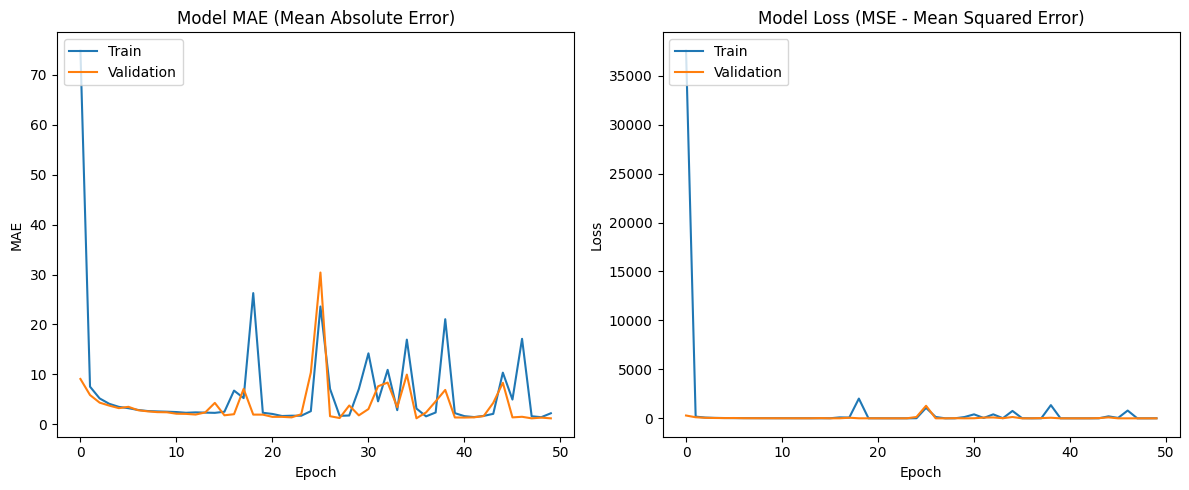

In [159]:
# Train a neural network model for rating prediction

# Start the timer
start_time = time.time()

# Create a neural network model
model = models.Sequential()

# Define input layer, hidden layers, and output layer
model.add(layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1))

# Compile the model, setting the optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
          
# Train the model using X_train and y_train, Validate the model on X_test and y_test
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    verbose=0)          

# End the timer
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

# After training, make predictions on the test set and evaluate the performance
# Plot training & validation MAE and loss values
plt.figure(figsize=(12, 5))

# MAE Plot (for regression, we plot mean absolute error)
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE - Mean Squared Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

The model exhibits significant volatility in both training and validation errors. The spikes in error suggest that the model might be overfitting or learning inconsistently across batches. 

This can be addressed by:
- Regularization: Add dropout layers or L2 regularization.
- Learning Rate Tuning: Decrease the learning rate to make the model's learning process smoother.
- Batch Normalization: Normalize the input for each layer to stabilize learning.

Total execution time: 173.39 seconds


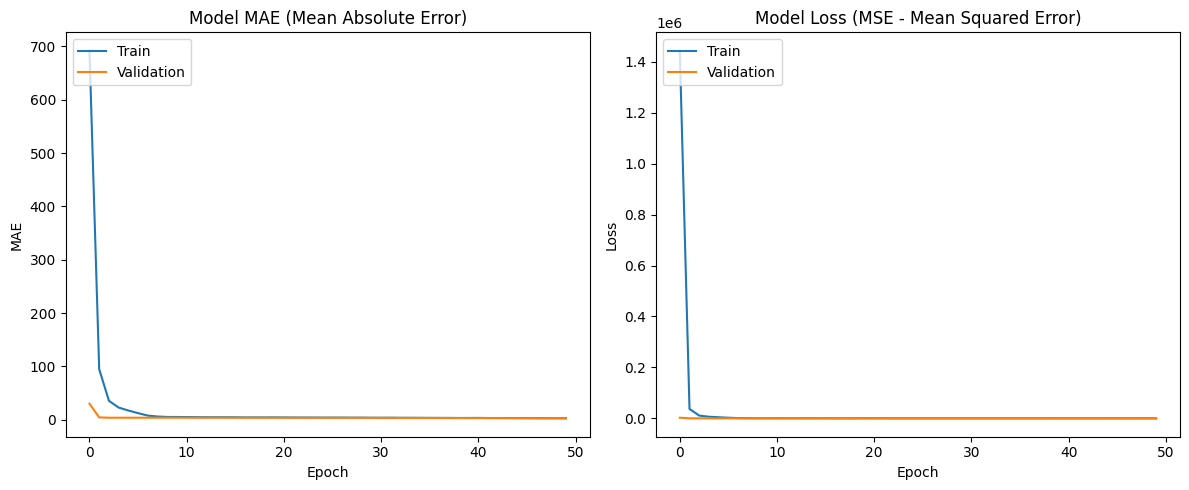

In [163]:
# Tune the model- Add Dropout Layers 

# Start the timer
start_time = time.time()

# build the model
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))  # Drop 20% of the neurons
model.add(layers.Dense(25, activation='relu'))
model.add(Dropout(0.2))  # Another dropout layer
model.add(layers.Dense(1))

# Compile the model, setting the optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
          
# Train the model using X_train and y_train, Validate the model on X_test and y_test
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    verbose=0)          

# End the timer
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

# After training, make predictions on the test set and evaluate the performance
# Plot training & validation MAE and loss values
plt.figure(figsize=(12, 5))

# MAE Plot (for regression, we plot mean absolute error)
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE - Mean Squared Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

When both the training and validation losses and errors drop to near 0, it's a sign that the model might not be generalizing well. 

Either:
- The task is too simple for the model, and it's solving it very easily, or
- The model is memorizing the data, leading to overfitting despite dropout being added.

Total execution time: 193.93 seconds


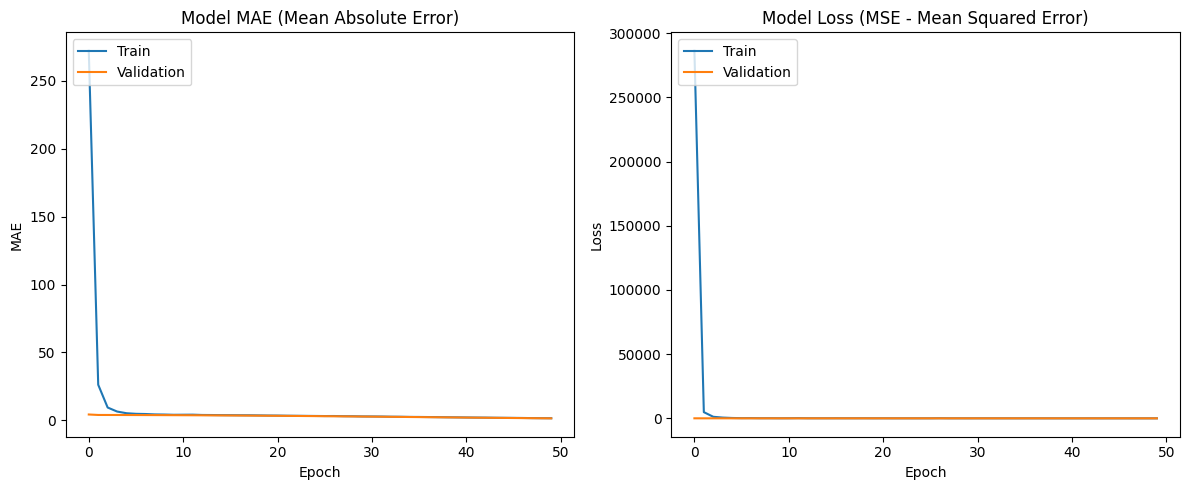

In [164]:
# Tune the model- Add L2 Regularization

# Start the timer
start_time = time.time()

# build the model
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],),
                       kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
model.add(Dropout(0.2))  
model.add(layers.Dense(25, activation='relu'))
model.add(Dropout(0.2))  
model.add(layers.Dense(1))

# Compile the model, setting the optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
          
# Train the model using X_train and y_train, Validate the model on X_test and y_test
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    verbose=0)          

# End the timer
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

# After training, make predictions on the test set and evaluate the performance
# Plot training & validation MAE and loss values
plt.figure(figsize=(12, 5))

# MAE Plot (for regression, we plot mean absolute error)
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE - Mean Squared Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

The latest plots show that both training and validation errors drop to near-zero quickly, indicating the model is likely overfitting to a simple task, even with dropout and L2 regularization. My earlier SVD model's strong performance (MAE: 0.3807) supports this, suggesting the task doesn't require a complex neural network. Next, I will simplify the model and use cross-validation to ensure it generalizes well.

Average Validation MAE: 1.6292227506637573
Average Validation Loss: 3.7303033828735352


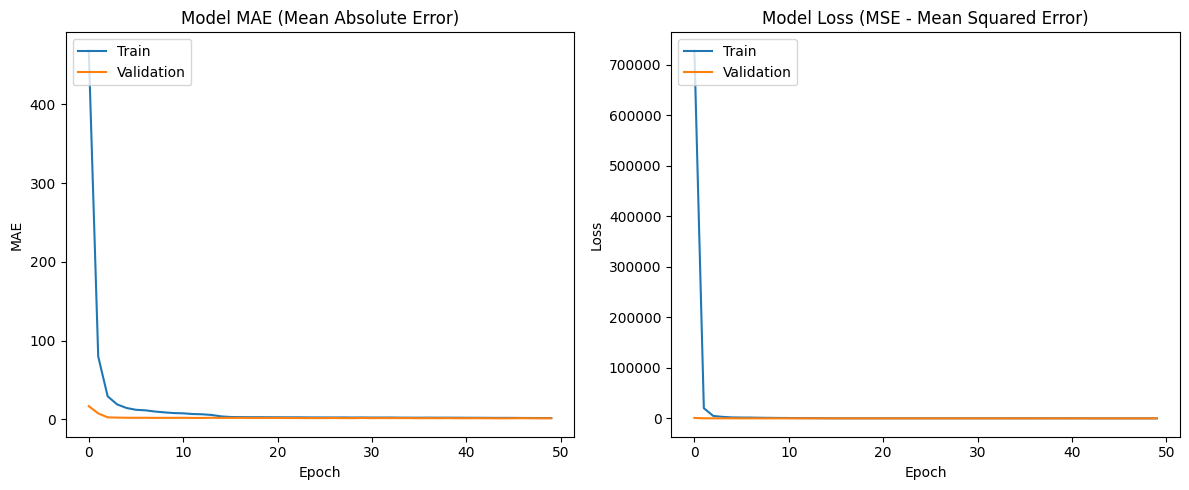

In [173]:
# Define the number of folds for cross-validation 
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define placeholders to store performance metrics 
mae_per_fold = []
loss_per_fold = []

# Loop through each fold
for train_index, val_index in kf.split(X_train):  

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Build a new model (resetting the model for each fold)
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  
    
    # Compile the model (define optimizer, loss, and metrics)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae'])

    # Train the model on the training set and validate on the validation set
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=256, 
                        validation_data=(X_val_fold, y_val_fold),
                        verbose=0)
    
    # Save the performance metrics for this fold (e.g., validation loss and accuracy)
    mae_per_fold.append(np.min(history.history['val_mae']))
    loss_per_fold.append(np.min(history.history['val_loss']))

# After all folds are complete, calculate the average performance across all folds
average_mae = np.mean(mae_per_fold)
average_loss = np.mean(loss_per_fold)

# Print or return the average performance to evaluate the model's generalization ability
print(f'Average Validation MAE: {average_mae}')
print(f'Average Validation Loss: {average_loss}')

# Plot training & validation MAE and loss values
plt.figure(figsize=(12, 5))

# MAE Plot (for regression, we plot mean absolute error)
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE - Mean Squared Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

The MAE and Loss on the validation set have reached relatively low values, indicating that the model generalizes well and shows no signs of overfitting. The error curves between the validation and training sets tend to stabilize, showing that the model has learned the patterns in the data effectively.